In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)
%matplotlib inline

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

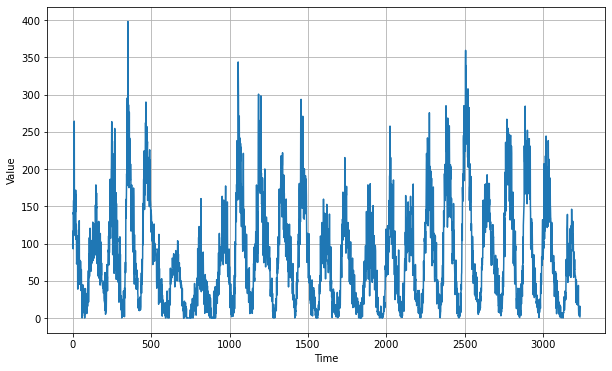

In [5]:
import csv
time_step = []
sunspots = []

with open('./tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

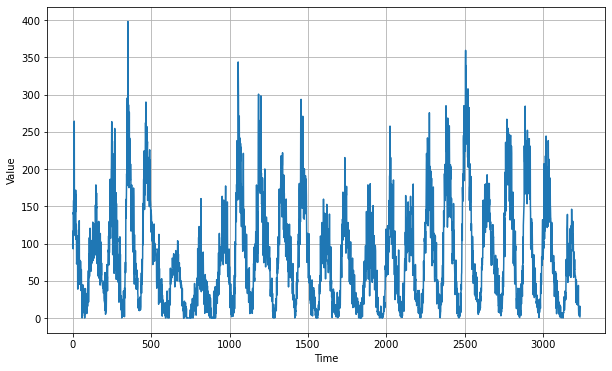

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 337ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 2s 169ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 2s 169ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 2s 167ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 2s 180ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 2s 169ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 2s 167ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 2s 159ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 2s 169ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 2s 164ms/step - loss: 21.6066 - mae: 21.6835
Epoch 83/100
12/12 [==============================] - 2s 165ms/step - loss: 27.7849 - mae: 28.5048
Epoch 84/100
12/12 [==============================] - 2s 189ms/step - loss: 25.9285 - mae: 26.2535
Epoch 85/100
12/12 [==============================] - 2s 163ms/step - loss: 23.2217 - mae: 23.6911
Epoch 86/100
12/12 [==============================] - 2s 168ms/step - loss: 23.9306 - mae: 23.5585
Epoch 87/100
12/12 [==============================] - 2s 161ms/step - loss: 35.6609 - mae: 35.9325
Epoch 88/100
12/12 [==============================] - 2s 160ms/step - loss: 31.1575 - mae: 31.5449
Epoch 89/100
12/12 [==============================] - 2s 162ms/step - loss: 47.2274 - mae: 47.1763
Epoch 90/100
12/12 [==============================] - 2s 161ms/step - loss: 49.5523 - mae: 50.6525
Epoch 91/100
12/12 [==============================] - 2s 161ms/step - loss: 66.0520 - mae: 66.7784
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

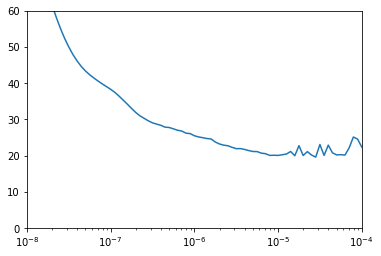

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 122ms/step - loss: 37.8969 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 2s 66ms/step - loss: 24.0752 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 2s 65ms/step - loss: 22.0254 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 2s 67ms/step - loss: 19.8260 - mae: 20.3089
Epoch 5/500
30/30 [==============================] - 2s 67ms/step - loss: 19.4916 - mae: 19.9757
Epoch 6/500
30/30 [==============================] - 2s 71ms/step - loss: 19.2049 - mae: 19.7011
Epoch 7/500
30/30 [==============================] - 2s 78ms/step - loss: 18.6486 - mae: 19.1466
Epoch 8/500
30/30 [==============================] - 2s 71ms/step - loss: 18.4395 - mae: 18.9531
Epoch 9/500
30/30 [==============================] - 2s 79ms/step - loss: 18.2435 - mae: 18.7159
Epoch 10/500
30/30 [==============================] - 2s 78ms/step - loss: 18.2594 - mae: 18.7128
Epoch 11/500
30/30 [========

30/30 [==============================] - 2s 77ms/step - loss: 16.3259 - mae: 16.8061
Epoch 85/500
30/30 [==============================] - 2s 79ms/step - loss: 16.3104 - mae: 16.7945
Epoch 86/500
30/30 [==============================] - 2s 72ms/step - loss: 16.3127 - mae: 16.7894
Epoch 87/500
30/30 [==============================] - 2s 65ms/step - loss: 16.3734 - mae: 16.8431
Epoch 88/500
30/30 [==============================] - 2s 72ms/step - loss: 16.8179 - mae: 17.2714
Epoch 89/500
30/30 [==============================] - 3s 86ms/step - loss: 16.3306 - mae: 16.8232
Epoch 90/500
30/30 [==============================] - 3s 86ms/step - loss: 16.3235 - mae: 16.8229
Epoch 91/500
30/30 [==============================] - 2s 75ms/step - loss: 16.3153 - mae: 16.8011
Epoch 92/500
30/30 [==============================] - 2s 74ms/step - loss: 16.3102 - mae: 16.7783
Epoch 93/500
30/30 [==============================] - 2s 71ms/step - loss: 16.3042 - mae: 16.7841
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 74ms/step - loss: 15.9265 - mae: 16.4294
Epoch 167/500
30/30 [==============================] - 2s 73ms/step - loss: 15.7927 - mae: 16.2816
Epoch 168/500
30/30 [==============================] - 2s 66ms/step - loss: 15.8185 - mae: 16.2843
Epoch 169/500
30/30 [==============================] - 2s 66ms/step - loss: 15.8675 - mae: 16.3451
Epoch 170/500
30/30 [==============================] - 2s 66ms/step - loss: 15.7420 - mae: 16.2398
Epoch 171/500
30/30 [==============================] - 2s 71ms/step - loss: 15.7551 - mae: 16.2350
Epoch 172/500
30/30 [==============================] - 2s 74ms/step - loss: 15.7230 - mae: 16.2045
Epoch 173/500
30/30 [==============================] - 2s 75ms/step - loss: 15.7685 - mae: 16.2692
Epoch 174/500
30/30 [==============================] - 2s 71ms/step - loss: 15.7910 - mae: 16.2790
Epoch 175/500
30/30 [==============================] - 2s 76ms/step - loss: 15.7965 - mae: 16.2842
Epoch 176/500
30/30 [===

30/30 [==============================] - 2s 76ms/step - loss: 15.3019 - mae: 15.7761
Epoch 249/500
30/30 [==============================] - 2s 81ms/step - loss: 15.3340 - mae: 15.7981
Epoch 250/500
30/30 [==============================] - 2s 75ms/step - loss: 15.2914 - mae: 15.7803
Epoch 251/500
30/30 [==============================] - 2s 74ms/step - loss: 15.2241 - mae: 15.7430
Epoch 252/500
30/30 [==============================] - 2s 73ms/step - loss: 15.2621 - mae: 15.7646
Epoch 253/500
30/30 [==============================] - 2s 70ms/step - loss: 15.2855 - mae: 15.7686
Epoch 254/500
30/30 [==============================] - 2s 71ms/step - loss: 15.3475 - mae: 15.8301
Epoch 255/500
30/30 [==============================] - 2s 83ms/step - loss: 15.1923 - mae: 15.7195
Epoch 256/500
30/30 [==============================] - 2s 73ms/step - loss: 15.3132 - mae: 15.7942
Epoch 257/500
30/30 [==============================] - 2s 72ms/step - loss: 15.4895 - mae: 15.9438
Epoch 258/500
30/30 [===

30/30 [==============================] - 2s 70ms/step - loss: 15.0645 - mae: 15.5434
Epoch 330/500
30/30 [==============================] - 2s 68ms/step - loss: 14.9396 - mae: 15.4284
Epoch 331/500
30/30 [==============================] - 2s 67ms/step - loss: 14.9421 - mae: 15.4431
Epoch 332/500
30/30 [==============================] - 2s 67ms/step - loss: 14.9034 - mae: 15.4020
Epoch 333/500
30/30 [==============================] - 2s 67ms/step - loss: 15.0310 - mae: 15.5236
Epoch 334/500
30/30 [==============================] - 2s 75ms/step - loss: 14.9076 - mae: 15.3772
Epoch 335/500
30/30 [==============================] - 2s 82ms/step - loss: 14.8649 - mae: 15.3679
Epoch 336/500
30/30 [==============================] - 2s 68ms/step - loss: 15.1398 - mae: 15.6160
Epoch 337/500
30/30 [==============================] - 2s 68ms/step - loss: 15.1367 - mae: 15.6288
Epoch 338/500
30/30 [==============================] - 2s 72ms/step - loss: 14.8916 - mae: 15.4114
Epoch 339/500
30/30 [===

30/30 [==============================] - 2s 70ms/step - loss: 14.6904 - mae: 15.1768
Epoch 412/500
30/30 [==============================] - 2s 68ms/step - loss: 14.5961 - mae: 15.0841
Epoch 413/500
30/30 [==============================] - 2s 70ms/step - loss: 14.5886 - mae: 15.0711
Epoch 414/500
30/30 [==============================] - 2s 75ms/step - loss: 14.5168 - mae: 15.0015
Epoch 415/500
30/30 [==============================] - 2s 67ms/step - loss: 14.5182 - mae: 15.0160
Epoch 416/500
30/30 [==============================] - 2s 68ms/step - loss: 14.5630 - mae: 15.0360
Epoch 417/500
30/30 [==============================] - 2s 70ms/step - loss: 14.4679 - mae: 14.9719
Epoch 418/500
30/30 [==============================] - 2s 66ms/step - loss: 14.4303 - mae: 14.9136
Epoch 419/500
30/30 [==============================] - 2s 67ms/step - loss: 14.5395 - mae: 15.0460
Epoch 420/500
30/30 [==============================] - 2s 68ms/step - loss: 14.4709 - mae: 14.9649
Epoch 421/500
30/30 [===

30/30 [==============================] - 2s 74ms/step - loss: 14.3552 - mae: 14.8363
Epoch 494/500
30/30 [==============================] - 2s 70ms/step - loss: 14.1257 - mae: 14.6247
Epoch 495/500
30/30 [==============================] - 2s 69ms/step - loss: 14.0888 - mae: 14.5811
Epoch 496/500
30/30 [==============================] - 2s 69ms/step - loss: 14.1731 - mae: 14.6328
Epoch 497/500
30/30 [==============================] - 2s 76ms/step - loss: 14.1507 - mae: 14.6117
Epoch 498/500
30/30 [==============================] - 2s 80ms/step - loss: 14.1200 - mae: 14.5944
Epoch 499/500
30/30 [==============================] - 2s 82ms/step - loss: 14.4022 - mae: 14.8840
Epoch 500/500
30/30 [==============================] - 2s 80ms/step - loss: 14.2950 - mae: 14.7574


In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

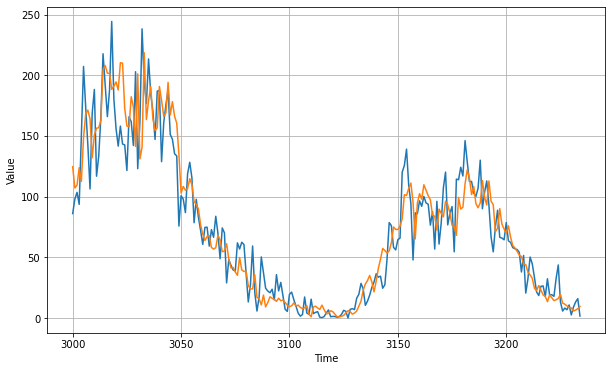

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.616489

<Figure size 432x288 with 0 Axes>

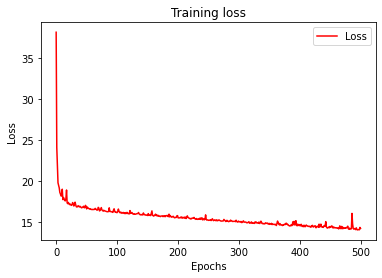

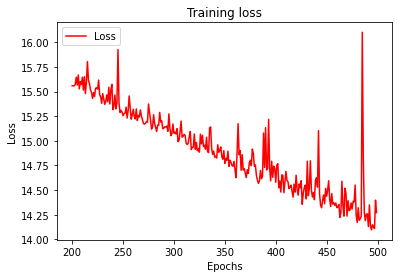

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[124.65134    107.077      109.35699    123.873726   112.54768
 148.41992    168.03096    171.25317    163.86678    131.9254
 151.01697    156.32957    156.7159     162.71413    204.64172
 208.03719    201.71092    201.51028    188.34358    191.02426
 194.49738    187.85506    210.30942    209.92216    172.66335
 158.17941    157.52235    182.29962    174.00615    141.31152
 201.12215    130.99004    140.68459    218.54643    163.4972
 179.15947    190.68846    164.35266    154.46674    156.63925
 190.74084    179.39305    166.08864    169.11603    194.12996
 167.2113     178.19435    166.28279    160.42494    134.59766
 102.96466    108.37548    105.222725   106.64198    114.71449
 109.98468     96.002365    93.443214    89.92463     76.732994
  68.99707     63.916092    67.17091     67.84356     58.0894
  56.82128     57.87058     68.16712     64.30668     54.651142
  55.003677    61.19492     48.55959     41.207184    41.59463
  37.89253     35.17675     49.79328     39.588154    38